In [5]:
import os
import datetime
import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt

import sys
sys.path.append('/home/rl_sim/thesis_ws/src/ML/UTILITIES')
from PreProcessingFunctions import WS, WS_B

from OrganizeReports import compare_and_organize
from Performance_plotter import plot_f1_score_threshold, plot_precision_recall_curve, plot_confusion_matrix, plot_roc_curve
from ML_models_functions import to_save_model, free_gpu_memory, save_datasummary_and_results
from XAI_FCN import plot_grad_cam

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from scipy.signal import butter, filtfilt
import traceback

import tensorflow
#gpus = tensorflow.config.list_physical_devices('GPU')
# if gpus:    
#     for gpu in gpus:
#         tensorflow.config.set_logical_device_configuration(
#             gpu,
#             [tensorflow.config.LogicalDeviceConfiguration(memory_limit=4*1024)])  # Adjust memory limit as needed

import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
for gpu in gpus:
    print(gpu)
# Set GPU 1 (the second GPU) to be the only visible device
if gpus:
    try:
        tf.config.set_visible_devices(gpus[1], 'GPU')
        
        # Optionally, set memory growth to avoid allocating all memory on the GPU at once
        tf.config.experimental.set_memory_growth(gpus[1], True)
    except RuntimeError as e:
        print(e)


from tensorflow.keras.models     import Sequential, Model, load_model
from tensorflow.keras.layers     import Input, Conv1D, Conv2D, BatchNormalization
from tensorflow.keras.layers     import Flatten, Dense, MaxPooling1D, MaxPooling2D, GlobalMaxPooling1D, GlobalMaxPooling2D
from tensorflow.keras.layers     import LeakyReLU, ReLU, Activation, Dropout, Lambda
from tensorflow.keras.layers     import concatenate, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.losses     import BinaryCrossentropy
from tensorflow.keras.metrics    import AUC
from tensorflow.keras.callbacks  import EarlyStopping

from tensorflow.keras.utils      import plot_model

def load_data(data_folder):
    X_data = []
    y_data = []
    
    # Traverse the data folder
    for file in os.listdir(data_folder):
        if file.endswith(".npz"):
            file_path = os.path.join(data_folder, file)
            data = np.load(file_path)
            X_data.append(data['X'])
            y_data.append(data['y'])
    
    # Stack the data into arrays
    X_data = np.vstack(X_data)
    y_data = np.hstack(y_data)
    
    return X_data, y_data


data_folder = '/home/rl_sim/thesis_ws/src/ML_ACTIONS/DATA/1D_LDG_FTP_ScalNorm'

X_data, y_data = load_data(data_folder)

# Check the shape of loaded data
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)
print("X_data.[0] shape: ", X_data[0].shape)
print("y_data.[0] max: ", np.max(y_data))

TEST_SIZE = 0.4
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size=TEST_SIZE, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"TOTAL DATA: {len(X_data)}  ||  Train = {100*(1-TEST_SIZE)}%  ||  Test = {100*TEST_SIZE}%")
print("Dimensions of X_train:", X_train.shape, "   ||  Dimensions of y_train:", y_train.shape)
print("Dimensions of X_test: ", X_test.shape, "   ||  Dimensions of y_test: ", y_test.shape)
print("Dimensions of X_val:  ", X_val.shape, "   ||  Dimensions of y_val:  ", y_val.shape)

data_dict = {
    "X_train": X_train,
    "X_val": X_val,
    "X_test": X_test
}

def assign_and_deploy_variables(data_dict):
    for key, data in data_dict.items():
        globals()[f"{key}1"] = np.dstack((data[:, :, 6], data[:, :, 8]))
        globals()[f"{key}2"] = np.dstack((data[:, :, 1], data[:, :, 5]))
        globals()[f"{key}3"] = np.dstack((data[:, :, 2], data[:, :, 4]))
        # Uncomment and modify the line below if you need the fourth set
        # globals()[f"{key}4"] = np.dstack((data[:, :, 6], data[:, :, 8]))

# Example usage
assign_and_deploy_variables(data_dict)

# Printing shapes
print("Shapes of the stacked arrays:")
print("X_train1 shape:", X_train1.shape)
print("X_train2 shape:", X_train2.shape)
print("X_train3 shape:", X_train3.shape)
#print("X_train4 shape:", X_train4.shape)


import tensorflow as tf

WS_B = 3000  # Example sequence length
input_shape1 = (WS_B, 2)
input_shape2 = (WS_B, 2)
input_shape3 = (WS_B, 2)

OUT_N = int(np.max(y_data)) + 1  # Plus one because labels are typically zero-indexed
DISP_LABELS = list(range(OUT_N))  # Generate labels from 0 to OUT_N-1
print("OUT_N:", OUT_N)
print("DISP_LABELS:", DISP_LABELS)

def compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=50, batch_size=32, patience=8, disp_labels=DISP_LABELS):
    # Compile the model
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, 
                        validation_data=(X_val, y_val), verbose=1, callbacks=[early_stopping])

    # Evaluate the model
    loss, accuracy = model.evaluate(X_test, y_test)

    # Predict labels for test data
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)

    # Plot training history
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))
    # Plot Loss Value
    axs[0].plot(history.history["loss"], label="loss (Training)")
    axs[0].plot(history.history["val_loss"], label="val_loss")
    axs[0].set_title("Loss Value")
    axs[0].set_xlabel('Epoch')
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(history.history["accuracy"], label="accuracy")
    axs[1].plot(history.history["val_accuracy"], label="val_accuracy")
    axs[1].set_title("Accuracy")
    axs[1].set_xlabel('Epoch')
    axs[1].legend()
    plt.tight_layout()
    plt.show()

    # Calculate additional metrics
    f1 = f1_score(y_test, y_pred_labels, average='macro') 
    accuracy = accuracy_score(y_test, y_pred_labels)

    print("Test loss:", loss)
    print("Test accuracy:", accuracy)
    print("F1 Score:", f1)
    print("Classification Report:\n", classification_report(y_test, y_pred_labels))

    # Confusion matrix
    conf_mat = confusion_matrix(y_test, y_pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=disp_labels)
    disp.plot(cmap=plt.cm.viridis)  # You can adjust the colormap as needed
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

    return history, loss, accuracy, f1, y_pred_labels

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
X_data shape: (430, 3000, 9)
y_data shape: (430,)
X_data.[0] shape:  (3000, 9)
y_data.[0] max:  3.0
TOTAL DATA: 430  ||  Train = 60.0%  ||  Test = 40.0%
Dimensions of X_train: (258, 3000, 9)    ||  Dimensions of y_train: (258,)
Dimensions of X_test:  (86, 3000, 9)    ||  Dimensions of y_test:  (86,)
Dimensions of X_val:   (86, 3000, 9)    ||  Dimensions of y_val:   (86,)
Shapes of the stacked arrays:
X_train1 shape: (258, 3000, 2)
X_train2 shape: (258, 3000, 2)
X_train3 shape: (258, 3000, 2)
OUT_N: 4
DISP_LABELS: [0, 1, 2, 3]


In [8]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 147, 256)  │    262,400 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 147, 256)  │    262,400 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 147, 256)  │    262,400 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 147, 256)  │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 147, 256)  │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 147, 256)  │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 146, 512)  │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 146, 512)  │    262,656 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 146, 512)  │    262,656 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 512)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 512)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1536)      │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     98,368 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        260 │ dense_1[0][0]   

 Total params: 1,704,900 (6.50 MB)

 Trainable params: 1,704,900 (6.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 5s 283ms/step - accuracy: 0.3008 - loss: 1.4068 - val_accuracy: 0.2558 - val_loss: 1.4231
Epoch 2/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4035 - loss: 1.2680 - val_accuracy: 0.5581 - val_loss: 1.0877
Epoch 3/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5992 - loss: 0.9580 - val_accuracy: 0.5814 - val_loss: 0.8547
Epoch 4/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5368 - loss: 1.0120 - val_accuracy: 0.5581 - val_loss: 0.9484
Epoch 5/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6453 - loss: 0.7530 - val_accuracy: 0.6628 - val_loss: 0.7999
Epoch 6/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6723 - loss: 0.7767 - val_accuracy: 0.5930 - val_loss: 0.8940
Epoch 7/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6426 - loss: 0.7255 - val_accuracy: 0.6047 - val_loss: 0.7615
Epoch 8/70
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7143 - loss: 0.6060 - val_accuracy: 0.6628 - val_loss: 0.6653
Epoch 

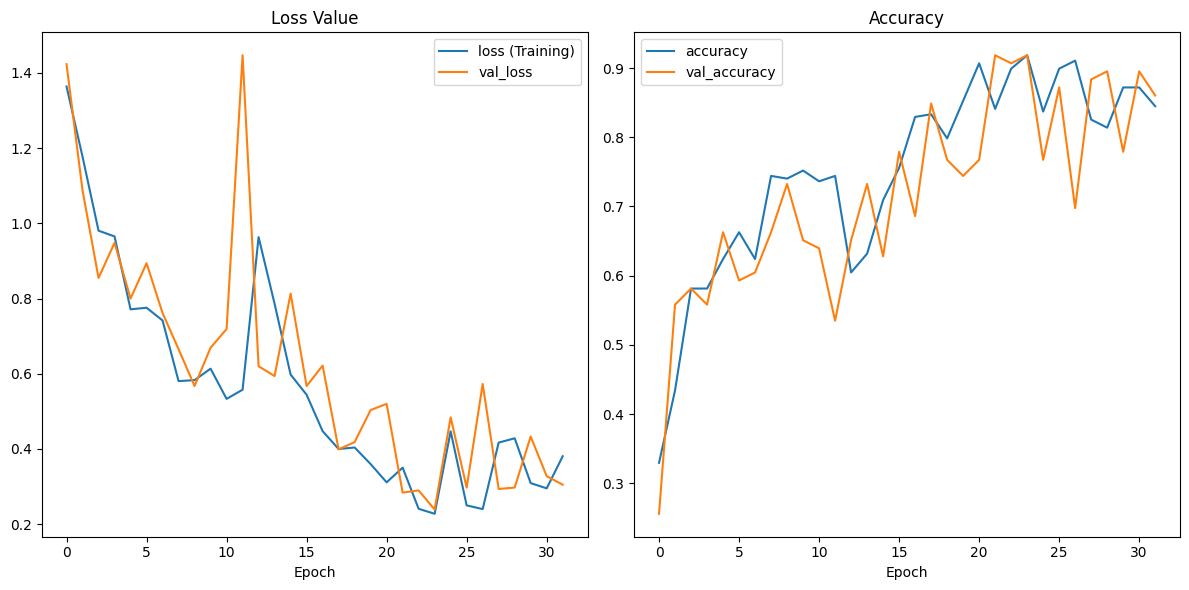

Test loss: 0.25514358282089233
Test accuracy: 0.9302325581395349
F1 Score: 0.9336842105263158
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        17
         1.0       0.96      0.96      0.96        25
         2.0       0.81      0.96      0.88        23
         3.0       1.00      0.81      0.89        21

    accuracy                           0.93        86
   macro avg       0.94      0.93      0.93        86
weighted avg       0.94      0.93      0.93        86



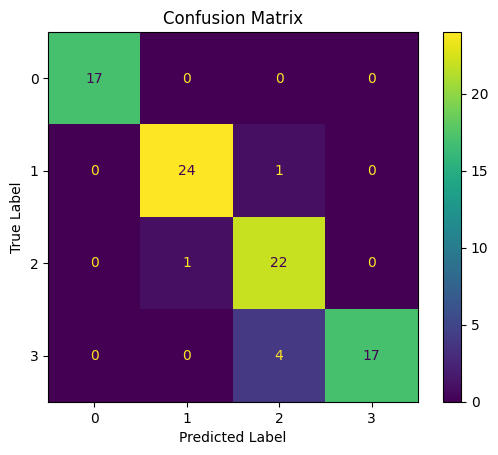

In [3]:
FILTN = 2
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        x = Conv1D(filters=128*FILTN, kernel_size=8, strides=2, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3]
model = build_branched_model(input_shapes)
model.summary()

X_train = [X_train1, X_train2, X_train3]
X_val   = [X_val1, X_val2, X_val3]
X_test  = [X_test1, X_test2, X_test3]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=70, batch_size=32, patience=8, disp_labels=DISP_LABELS)

y_pred: 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


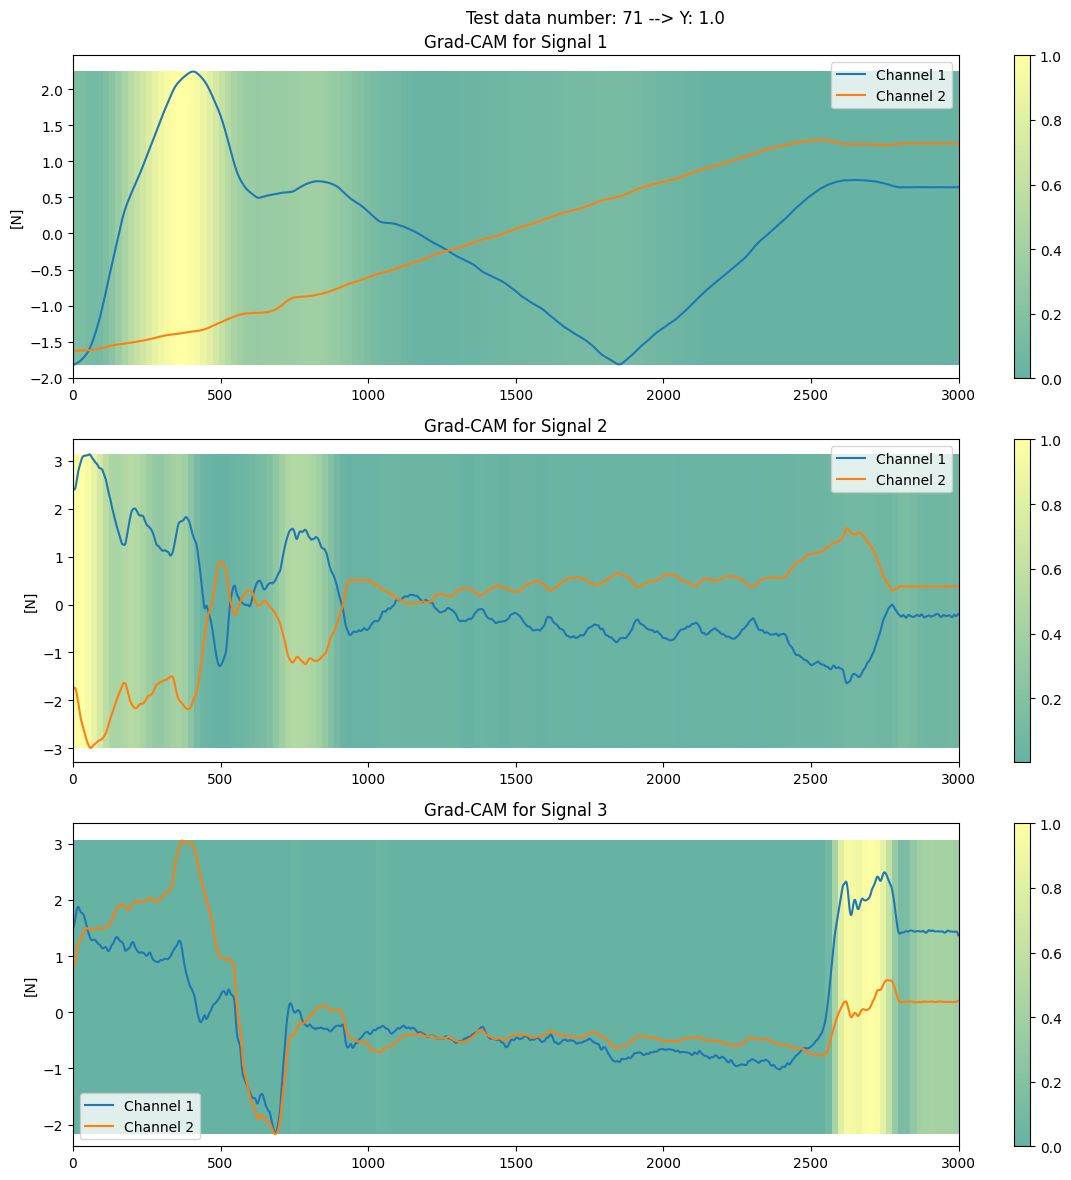

In [34]:
print(f"y_pred: {y_pred_labels[71]}")
plot_grad_cam(model, [X_test1, X_test2, X_test3], 71, y_test, ['conv1d_1_3', 'conv1d_2_3', 'conv1d_3_3'])

In [10]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input1 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input2 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input3 (InputLayer) │ (None, 3000, 2)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_1 (Conv1D) │ (None, 300, 128)  │     10,368 │ input3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_2 (Conv1D) │ (None, 297, 256)  │    131,328 │ conv1d_1_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_2 (Conv1D) │ (None, 297, 256)  │    131,328 │ conv1d_2_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_2 (Conv1D) │ (None, 297, 256)  │    131,328 │ conv1d_3_1[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1_1         │ (None, 297, 256)  │          0 │ conv1d_1_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2_1         │ (None, 297, 256)  │          0 │ conv1d_2_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3_1         │ (None, 297, 256)  │          0 │ conv1d_3_2[0][0]  │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1_3 (Conv1D) │ (None, 296, 512)  │    262,656 │ dropout_1_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2_3 (Conv1D) │ (None, 296, 512)  │    262,656 │ dropout_2_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3_3 (Conv1D) │ (None, 296, 512)  │    262,656 │ dropout_3_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_1_1           │ (None, 512)       │          0 │ conv1d_1_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_2_1           │ (None, 512)       │          0 │ conv1d_2_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap1d_3_1           │ (None, 512)       │          0 │ conv1d_3_3[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 1536)      │          0 │ gap1d_1_1[0][0],  │
│ (Concatenate)       │                   │            │ gap1d_2_1[0][0],  │
│                     │                   │            │ gap1d_3_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │     98,368 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 4)         │        260 │ dense_1[0][0]   

 Total params: 1,311,684 (5.00 MB)

 Trainable params: 1,311,684 (5.00 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 182ms/step - accuracy: 0.3562 - loss: 1.3554 - val_accuracy: 0.2891 - val_loss: 1.5626
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5018 - loss: 1.0761 - val_accuracy: 0.5000 - val_loss: 1.0119
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6199 - loss: 0.8795 - val_accuracy: 0.6016 - val_loss: 0.7775
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6834 - loss: 0.6353 - val_accuracy: 0.6641 - val_loss: 0.6839
Epoch 5/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7183 - loss: 0.6047 - val_accuracy: 0.8516 - val_loss: 0.4362
Epoch 6/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8418 - loss: 0.3915 - val_accuracy: 0.6172 - val_loss: 0.6505
Epoch 7/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7770 - loss: 0.4642 - val_accuracy: 0.6641 - val_loss: 0.5463
Epoch 8/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8518 - loss: 0.3748 - val_accuracy: 0.8672 - val_los

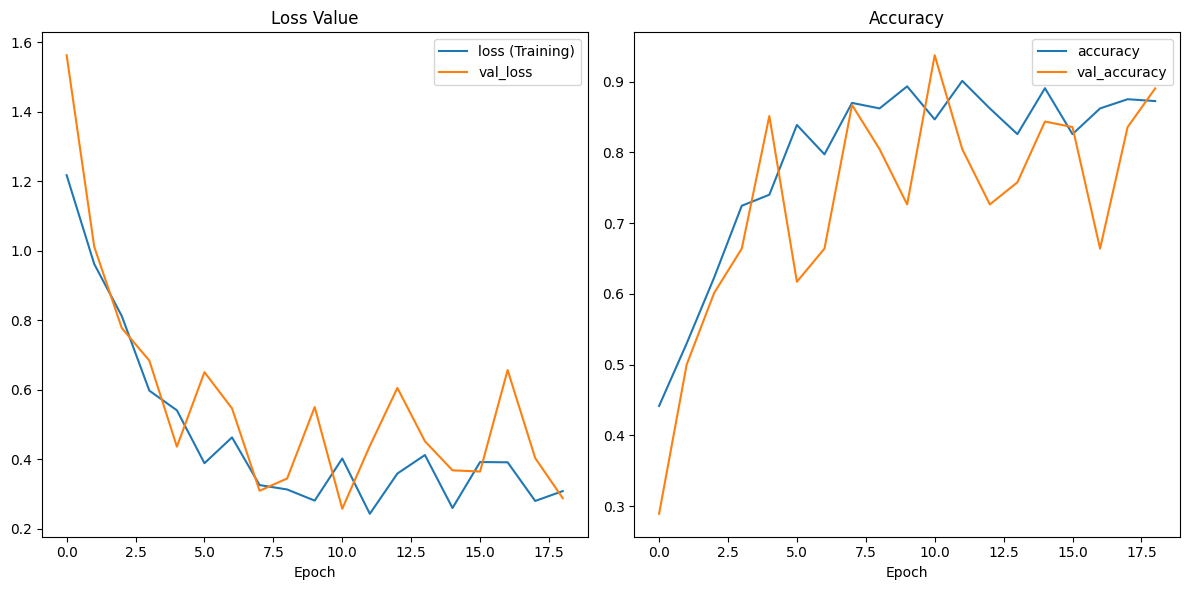

Test loss: 0.35115209221839905
Test accuracy: 0.875968992248062
F1 Score: 0.8789781565983925
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      0.97      0.98        29
         1.0       0.87      0.93      0.90        28
         2.0       0.75      0.77      0.76        31
         3.0       0.90      0.85      0.88        41

    accuracy                           0.88       129
   macro avg       0.88      0.88      0.88       129
weighted avg       0.88      0.88      0.88       129



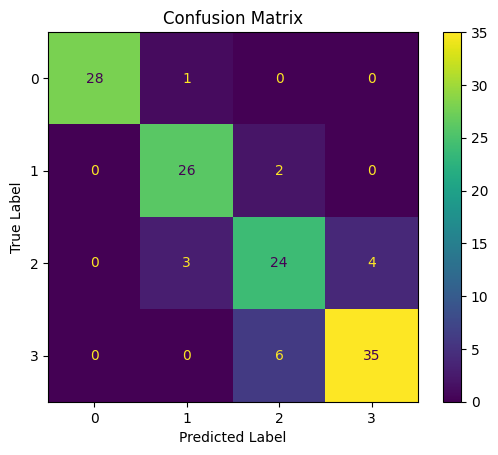

In [11]:
FILTN = 2
def build_branched_model(input_shapes):
    def create_branch(input_shape, branch_id):
        input_layer = Input(shape=input_shape, name=f'input{branch_id}')
        x = Conv1D(filters=64*FILTN, kernel_size=40, strides=10, activation='relu', padding='same', name=f'conv1d_{branch_id}_1')(input_layer)
        x = Conv1D(filters=128*FILTN, kernel_size=4, strides=1, activation='relu', name=f'conv1d_{branch_id}_2')(x)
        x = Dropout(rate=0.2, name=f'dropout_{branch_id}_1')(x)
        x = Conv1D(filters=256*FILTN, kernel_size=2, strides=1, activation='relu', name=f'conv1d_{branch_id}_3')(x)
        x = GlobalMaxPooling1D(name=f'gap1d_{branch_id}_1')(x)
        return input_layer, x

    inputs = []
    branches = []
    
    for i, input_shape in enumerate(input_shapes, 1):
        input_layer, branch_output = create_branch(input_shape, i)
        inputs.append(input_layer)
        branches.append(branch_output)
    
    merged = concatenate(branches, name='concatenate_1')
    
    # Dense layers
    dense = Dense(64, activation='relu', name='dense_1')(merged)
    #dense = Dense(16, activation='relu', name='dense_2')(dense)
    
    # Output layer for 6-class classification
    output = Dense(OUT_N, activation='softmax', name='output')(dense)
    
    model = Model(inputs=inputs, outputs=output)
    return model

# Example usage:
input_shapes = [input_shape1, input_shape2, input_shape3]
model = build_branched_model(input_shapes)
model.summary()


X_train = [X_train1, X_train2, X_train3]
X_val   = [X_val1, X_val2, X_val3]
X_test  = [X_test1, X_test2, X_test3]

history, loss, accuracy, f1, y_pred_labels = compile_train_evaluate_plot(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=60, batch_size=32, patience=8, disp_labels=DISP_LABELS)

In [12]:
# model_name = "MOD_AUG_KNOB_3Cnv_128Dens_400WideKern_96"
# save_datasummary_and_results(model, history, loss, accuracy, f1, model_name, y_test, y_pred_labels, build_branched_model, assign_and_deploy_variables)
# #model.save(f"{model_name}.h5")
# from tensorflow.keras.models import save_model
# save_dir = "saved_models/"
# os.makedirs(save_dir, exist_ok=True)
# model_path = os.path.join(save_dir, f"{model_name}.keras")
# save_model(model, model_path)